# Network analysis in Senegal

### Objectives
    1)	Use measures of road-based accessibility to identify road segments that, if rehabilitated, would improve agricultural market activities in Senegal, including during flood conditions.
    2)	Gain a better understanding of the accessibility, connectivity, and criticality of roads in Senegal in relationship to agricultural origins, processing & transfer sites, and markets.

To this end, the team will develop an accessibility model which measures the travel time from sites of agricultural production to their nearest populated areas, processing centers, and markets. 

### Datasets for analysis
#### ORIGIN
    1) agriculture: MapSPAM 2017. Measuring value in international dollars.
    2) agriculture: UMD Land Cover 2019 30m. Assign MapSPAM value onto land cover cropland class for more precise origin information.
    3) population: WorldPop 2020, UN-adjusted.
    4) settlement extent: GRID3 2020.
#### DESTINATION
    4) markets: derived from WorldPop 2020 and GRID3 2020 urban clusters.
    5) agricultural processing hubs: to be acquired.
#### TRAVEL ROUTE
    6) roads: OpenStreetMap, July 2021.
    7) elevation: 
#### OBSTACLE
    8) flood: FATHOM. 1-in-10, 20, and 50 year flood return periods. These are combined pluvial and fluvial (undefended) flood layers whereby whichever flood level was higher was retained.
#### INTERVENTION
    9) upcoming road projects: AGEROUTE interventions separate from the World Bank-financed project
    10) targeted road projects: critical road segments identified by this accessibility model's baseline outputs


### Model design
#### Basic formula: 
    (a) Off-road driving time from origin to closest road node
    +
    (b) Driving time from road node in (a) to a destination (closeness measured by road segments speeds)

#### Model origin & destination (OD) sets:
    A)	Travel time from an area that has agricultural value/potential to the nearest processing hub (if provided).
    B)	Travel time from an area that has agricultural value/potential to the nearest larger settlement, (“larger” settlement identified using a case-appropriate population metric to be determined).
    C)	Travel time from an area that has agricultural value/potential to the nearest market.
    D)	Travel time from all settlements to the nearest market.
    E)	Travel time from larger settlements to the nearest market.

#### Before/after scenarios for each OD set:
    1)	Pre-project, baseline weather: No inclement weather. Road network status as of November 2021.
    2)	Pre-project, flood: 1-in-10, 1-in-20 and 1-in-50 year flood return period. Road network status as of November 2021.
    3)	Post-project, baseline weather: No inclement weather. Road network status if X number of critical road segments to high-value areas are protected (i.e., their travel times reduced).
    4)	Post-project, flood: 1-in-10 year flood return period. Road network status if X number of critical road segments to high-value areas are protected (i.e., their travel times reduced).

#### Notes:
    --Destinations are expected to be proximal to the road network, so no measure is taken between road and destination.
    --All travel times will be assigned to each model variation’s point of origin; the aggregation up to admin areas is possible if desired.
    --Obstacles & interventions modify the road segment speeds. Basic formula is then applied to the modified road network.


### Prep workspace

In [1]:
import os, sys
GISFolder = os.getcwd()
GISFolder

'C:\\Users\\wb527163\\GEO-Cdrive-Grace'

In [2]:
# Note: needed to reinstall rtree due to geopandas import error. Did so in the console. 
# conda install -c conda-forge rtree=0.9.3

In [3]:
# load and filter osm network (step 1)
import geopandas as gpd
from geopandas import GeoDataFrame
import pandas as pd
import time
sys.path.append(r"C:\Users\wb527163\.conda\envs\geo\GOSTnets-master")
import GOSTnets as gn

In [4]:
import networkx as nx
import osmnx as ox
import numpy as np
import rasterio as rt
import shapely
from shapely.geometry import Point, box, Polygon
from shapely.ops import unary_union, linemerge, transform
from shapely.wkt import loads
from shapely import wkt
from shapely.geometry import LineString, MultiLineString, Point
import peartree

In [5]:
#### Might not use these
import fiona
from osgeo import gdal
import importlib
import matplotlib.pyplot as plt
import subprocess, glob

In [6]:
from GOSTnets import load_osm as losm
import importlib

In [7]:
pth = os.path.join(GISFolder, "SEN-Cdrive") # Personal folder system for running model.
pth

'C:\\Users\\wb527163\\GEO-Cdrive-Grace\\SEN-Cdrive'

In [8]:
out_pth = os.path.join(GISFolder, "SEN-Cdrive\outputs") # For storing intermediate outputs from the model.
out_pth

'C:\\Users\\wb527163\\GEO-Cdrive-Grace\\SEN-Cdrive\\outputs'

In [9]:
team_pth = 'R:\\SEN\\GEO' # This is where the unmodified input data is stored. Finalized outputs also housed here.
team_pth

'R:\\SEN\\GEO'

### Prepare OSM driving network.
Travel measured in length (meters).

In [10]:
# Earlier, created an approximate bounding area which includes parts of neighboring countries and all of The Gambia.
aoi = gpd.read_file("R:/SEN/GEO/Roads/bounding_senegam_buffered.shp") # AOI = Area of Interest
print(aoi)

   id       bound                                           geometry
0   0  senegambia  POLYGON ((-16.79591 16.13764, -16.44946 16.908...


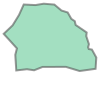

In [11]:
bound = aoi.geometry.iloc[0]
bound # Check that it's shaped like Senegal & Gambia.

In [12]:
aoi.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [13]:
print('start: %s\n' % time.ctime())
gDrive = ox.graph_from_polygon(bound, network_type= 'all', simplify=False, clean_periphery=False)
# Note: length is measured in meters.
print('\nend: %s' % time.ctime())
print('\n--- processing complete')

start: Thu Jan  6 12:19:39 2022



C:\Users\wb527163\.conda\envs\geo\lib\site-packages\osmnx-1.1.1-py3.8.egg\osmnx\utils_geo.py:335: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
C:\Users\wb527163\.conda\envs\geo\lib\site-packages\osmnx-1.1.1-py3.8.egg\osmnx\utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:



end: Thu Jan  6 12:38:58 2022

--- processing complete


In [14]:
gn.save(gDrive, 'SEN-Cdrive/gDrive', '', edges = True, nodes = True)

In [15]:
gn.example_edge(gDrive, 2)

(358284990, 5217543379, {'osmid': 59618174, 'ref': 'D 523', 'name': 'D 523', 'highway': 'unclassified', 'oneway': False, 'length': 33.127})
(358284990, 1888282175, {'osmid': 178482063, 'highway': 'tertiary', 'oneway': False, 'length': 12.832})


In [ ]:
# If restarting, reload.
gDrive = nx.read_gpickle("SEN-Cdrive/gDrive.pickle")

In [28]:
gDrive_edge = gn.edge_gdf_from_graph(gDrive)
gDrive_node = gn.edge_gdf_from_graph(gDrive)
gDrive_edge

,stnode,endnode,length,area,junction,tunnel,osmid,access,maxspeed,oneway,service,width,highway,lanes,landuse,bridge,name,ref,geometry
0,358284990,5217543379,33.127,NaN,NaN,NaN,59618174,NaN,NaN,False,NaN,NaN,unclassified,NaN,NaN,NaN,D 523,D 523,"LINESTRING (-12.32347 12.38119, -12.32368 12.3..."
1,358284990,1888282175,12.832,NaN,NaN,NaN,178482063,NaN,NaN,False,NaN,NaN,tertiary,NaN,NaN,NaN,NaN,NaN,"LINESTRING (-12.32347 12.38119, -12.32351 12.3..."
2,358284990,5329792467,48.781,NaN,NaN,NaN,178482063,NaN,NaN,False,NaN,NaN,tertiary,NaN,NaN,NaN,NaN,NaN,"LINESTRING (-12.32347 12.38119, -12.32317 12.3..."
3,358284993,1888282575,126.577,NaN,NaN,NaN,178470940,NaN,NaN,False,NaN,NaN,tertiary,NaN,NaN,NaN,NaN,NaN,"LINESTRING (-12.28135 12.41380, -12.28205 12.4..."
4,358284993,1888198886,120.578,NaN,NaN,NaN,178470940,NaN,NaN,False,NaN,NaN,tertiary,NaN,NaN,NaN,NaN,NaN,"LINESTRING (-12.28135 12.41380, -12.28061 12.4..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6203378,9246539941,9246539942,76.742,NaN,NaN,NaN,366052716,NaN,NaN,False,NaN,NaN,residential,NaN,NaN,NaN,NaN,NaN,"LINESTRING (-17.48521 14.72445, -17.48451 14.7..."
6203379,9246539942,9246539941,76.742,NaN,NaN,NaN,366052716,NaN,NaN,False,NaN,NaN,residential,NaN,NaN,NaN,NaN,NaN,"LINESTRING (-17.48451 14.72456, -17.48521 14.7..."
6203380,9246539942,3700438702,0.846,NaN,NaN,NaN,366052716,NaN,NaN,False,NaN,NaN,residential,NaN,NaN,NaN,NaN,NaN,"LINESTRING (-17.48451 14.72456, -17.48451 14.7..."
6203381,9276108905,6048975958,171.902,NaN,NaN,NaN,177950649,NaN,NaN,True,NaN,NaN,secondary,2,NaN,NaN,Route de l'Aeroport,NaN,"LINESTRING (-17.50499 14.74971, -17.50357 14.7..."


In [29]:
gDrive_edge.reset_index(inplace=True) # To create unique ID and to avoid:  ValueError: cannot reindex from a duplicate axis.
gDrive_edge.rename(columns={'index': 'ID_graph'}, inplace=True)
print(gDrive_edge.info())

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 6203383 entries, 0 to 6203382
Data columns (total 20 columns):
 #   Column    Dtype   
---  ------    -----   
 0   ID_graph  int64   
 1   stnode    int64   
 2   endnode   int64   
 3   length    float64 
 4   area      object  
 5   junction  object  
 6   tunnel    object  
 7   osmid     int64   
 8   access    object  
 9   maxspeed  object  
 10  oneway    bool    
 11  service   object  
 12  width     object  
 13  highway   object  
 14  lanes     object  
 15  landuse   object  
 16  bridge    object  
 17  name      object  
 18  ref       object  
 19  geometry  geometry
dtypes: bool(1), float64(1), geometry(1), int64(4), object(13)
memory usage: 905.1+ MB
None


#### Convert the graph to time, then save to file. Edges contain the time measure.

In [13]:
speed_dict = {
                'residential': 40,  # kmph
                'primary': 80, 
                'primary_link':60,
                'trunk': 80,
                'trunk_link':60,
                'secondary': 70, 
                'secondary_link':50,
                'service': 40,
                'tertiary':60,
                'tertiary_link': 40,
                'unclassified':50, 
                'road':50,
                'track':20,
                'path':4.5,
                }

In [14]:
print('start: %s\n' % time.ctime())
gTime = gn.convert_network_to_time(gDrive, distance_tag = 'length', graph_type='drive', speed_dict = speed_dict)
# Note: time is in seconds.
print('\nend: %s' % time.ctime())
print('\n--- processing complete')

start: Thu Jan  6 22:06:59 2022


end: Thu Jan  6 22:09:50 2022

--- processing complete


Compare the roads before and after converting to time to make sure the time looks accurate.

In [15]:
print("No time variable\n")
print(gn.example_edge(gDrive, 2))
print("\n\nTime variable\n") 
print(gn.example_edge(gTime, 2))

No time variable

(358284990, 5217543379, {'osmid': 59618174, 'ref': 'D 523', 'name': 'D 523', 'highway': 'unclassified', 'oneway': False, 'length': 33.127})
(358284990, 1888282175, {'osmid': 178482063, 'highway': 'tertiary', 'oneway': False, 'length': 12.832})
None
Time variable

(358284990, 5217543379, {'osmid': 59618174, 'ref': 'D 523', 'name': 'D 523', 'highway': 'unclassified', 'oneway': False, 'length': 33.127, 'time': 2.3851440000000004, 'mode': 'drive'})
(358284990, 1888282175, {'osmid': 178482063, 'highway': 'tertiary', 'oneway': False, 'length': 12.832, 'time': 0.76992, 'mode': 'drive'})
None


#### Ensure all targeted roads start as "track" class of road (except Mboro-Diogo), per client advice. 

In [25]:
targeted = os.path.join(pth, "targeted_roads_osmid.csv")
targeted = pd.read_csv(targeted)
print(targeted.info(), end="\n\n")
targeted = targeted[['id']]
targeted['id'] = targeted['id'].str.replace(r'\D', '').astype(int)
targeted = targeted.drop([targeted.index[49]]) # Mboro-Diogo stays the same.
target_list = list(targeted.id)
print(target_list)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59 entries, 0 to 58
Data columns (total 35 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          59 non-null     object 
 1   @id         59 non-null     object 
 2   highway     59 non-null     object 
 3   name        5 non-null      object 
 4   oneway      26 non-null     object 
 5   smoothness  2 non-null      object 
 6   surface     48 non-null     object 
 7   access      0 non-null      float64
 8   note        0 non-null      float64
 9   source      0 non-null      float64
 10  tracktype   17 non-null     object 
 11  bridge      0 non-null      float64
 12  layer       0 non-null      float64
 13  embankment  0 non-null      float64
 14  ref         3 non-null      object 
 15  lanes       21 non-null     float64
 16  maxspeed    7 non-null      float64
 17  lit         0 non-null      float64
 18  ford        0 non-null      float64
 19  fixme       0 non-null      flo

C:\Users\wb527163\AppData\Local\Temp/ipykernel_7412/529551811.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  targeted['id'] = targeted['id'].str.replace(r'\D', '').astype(int)


In [ ]:
edges = gn.edge_gdf_from_graph(gTime) 
nodes = gn.node_gdf_from_graph(gTime)

In [17]:
print(edges.info(), end="\n")
print(nodes.info(), end="\n") 
print(edges['highway'].value_counts())

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 6203383 entries, 0 to 6203382
Data columns (total 21 columns):
 #   Column    Dtype   
---  ------    -----   
 0   stnode    int64   
 1   endnode   int64   
 2   length    float64 
 3   width     object  
 4   area      object  
 5   highway   object  
 6   ref       object  
 7   maxspeed  object  
 8   time      float64 
 9   name      object  
 10  mode      object  
 11  lanes     object  
 12  tunnel    object  
 13  bridge    object  
 14  junction  object  
 15  landuse   object  
 16  access    object  
 17  osmid     int64   
 18  service   object  
 19  oneway    bool    
 20  geometry  geometry
dtypes: bool(1), float64(2), geometry(1), int64(3), object(14)
memory usage: 952.5+ MB
None
<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 2871182 entries, 0 to 2871181
Data columns (total 6 columns):
 #   Column    Dtype   
---  ------    -----   
 0   node_ID   int64   
 1   highway   object  
 2   ref       obje

In [26]:
print(sum(edges['osmid'].isin(target_list)))

6296


In [27]:
print("Original\n")
print(edges['time'].mean())
edges.loc[edges['osmid'].isin(target_list),
          'time'] = (edges['length']/1000) / 20 * 60 * 60 # Length over speed (20kmph), converted to seconds.
print("\n\nAccording to govt records\n")
print(edges['time'].mean()) # Making sure this changed the data.

Original

6.53490893401129


According to govt records

6.548675420775734


In [ ]:
edges.to_csv(os.path.join(out_pth, "gTime_edge_pre-project.csv"))
nodes.to_csv(os.path.join(out_pth, "gTime_node_pre-project.csv"))

In [10]:
# Converting back to graph can cause memory errors. Suggested to restart the kernel and reload the nodes and revised edges at this point.
nodes = os.path.join(out_pth, "gTime_node_pre-project.csv")
nodes = pd.read_csv(nodes)
edges = os.path.join(out_pth, "gTime_edge_pre-project.csv")
edges = pd.read_csv(edges)
print(nodes.info())
print(edges.info())

C:\Users\wb527163\.conda\envs\geo\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\wb527163\.conda\envs\geo\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (4,5,7,8,10,13,14,15,16,17,19) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2871182 entries, 0 to 2871181
Data columns (total 7 columns):
 #   Column      Dtype  
---  ------      -----  
 0   Unnamed: 0  int64  
 1   node_ID     int64  
 2   highway     object 
 3   ref         object 
 4   y           float64
 5   x           float64
 6   geometry    object 
dtypes: float64(2), int64(2), object(3)
memory usage: 153.3+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6203383 entries, 0 to 6203382
Data columns (total 22 columns):
 #   Column      Dtype  
---  ------      -----  
 0   Unnamed: 0  int64  
 1   stnode      int64  
 2   endnode     int64  
 3   length      float64
 4   width       object 
 5   area        object 
 6   highway     object 
 7   ref         object 
 8   maxspeed    object 
 9   time        float64
 10  name        object 
 11  mode        object 
 12  lanes       float64
 13  tunnel      object 
 14  bridge      object 
 15  junction    object 
 16  landuse     object 
 17  a

In [12]:
print('start: %s\n' % time.ctime())
gTime = gn.edges_and_nodes_gdf_to_graph(nodes, edges, node_tag='node_ID', u_tag='stnode', v_tag='endnode', geometry_tag='geometry')
gn.example_edge(gTime, 10)
print('\nend: %s' % time.ctime())
print('\n--- processing complete')

start: Thu Jan  6 23:08:21 2022

(358284990, 5217543379, {'geometry': <shapely.geometry.linestring.LineString object at 0x000001C1233B0EB0>, 'Unnamed: 0': 0, 'length': 33.127, 'width': nan, 'area': nan, 'highway': 'unclassified', 'ref': 'D 523', 'maxspeed': nan, 'time': 2.3851440000000004, 'name': 'D 523', 'mode': 'drive', 'lanes': nan, 'tunnel': nan, 'bridge': nan, 'junction': nan, 'landuse': nan, 'access': nan, 'osmid': 59618174, 'service': nan, 'oneway': False})
(358284990, 1888282175, {'geometry': <shapely.geometry.linestring.LineString object at 0x000001C1233B0E80>, 'Unnamed: 0': 1, 'length': 12.832, 'width': nan, 'area': nan, 'highway': 'tertiary', 'ref': nan, 'maxspeed': nan, 'time': 0.76992, 'name': nan, 'mode': 'drive', 'lanes': nan, 'tunnel': nan, 'bridge': nan, 'junction': nan, 'landuse': nan, 'access': nan, 'osmid': 178482063, 'service': nan, 'oneway': False})
(358284990, 5329792467, {'geometry': <shapely.geometry.linestring.LineString object at 0x000001C0ECA03CA0>, 'Unname

In [13]:
# Save a pickle of the graph and csvs of the edges and nodes with the time measure for easy recall.
gn.save(gTime, 'gTime_pre-project', out_pth, edges = False, nodes = False)

### Origins and destinations

Measure distance from origin/destination to nearest node and save to file.

In [10]:
#%% If starting new session, reload graph from file
gTime = nx.read_gpickle("SEN-Cdrive/outputs/gTime_pre-project.pickle")

In [11]:
HDurban_pt = gpd.read_file("SEN-Cdrive/outputs/HDurban_pt.shp")
hamlet_pt = gpd.read_file("SEN-Cdrive/outputs/hamlet_pt.shp")
HDurban_pt = HDurban_pt.to_crs("EPSG:4326")
hamlet_pt = hamlet_pt.to_crs("EPSG:4326")
print(HDurban_pt.info())
print("\n\n")
print(hamlet_pt.info())

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 58 entries, 0 to 57
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   Unnamed_ 0  58 non-null     int64   
 1   mgrs_code   58 non-null     object  
 2   type        58 non-null     object  
 3   AREA_GEO    58 non-null     float64 
 4   SUM         58 non-null     float64 
 5   Total_Driv  57 non-null     float64 
 6   WP_dens     58 non-null     float64 
 7   urb         58 non-null     int64   
 8   hd_urb      58 non-null     int64   
 9   Urb_class   58 non-null     int64   
 10  Shape_Leng  58 non-null     float64 
 11  Shape_Area  58 non-null     float64 
 12  geometry    58 non-null     geometry
dtypes: float64(6), geometry(1), int64(4), object(2)
memory usage: 6.0+ KB
None



<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 125886 entries, 0 to 125885
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype   
---  ------    

In [10]:
print('start: %s\n' % time.ctime())
agriculture = gpd.read_file("R:\SEN\GEO\Team\Projects\Sen_TransportOV\SEN_TransportOV.gdb", layer="agriculture_allorigins")
agriculture = agriculture.to_crs('EPSG:4326')
agriculture.info()
print('\nend: %s' % time.ctime())
print('\n--- processing complete')

start: Fri Jan  7 11:10:53 2022

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 13941124 entries, 0 to 13941123
Data columns (total 9 columns):
 #   Column    Dtype   
---  ------    -----   
 0   ID_ag     int64   
 1   ID_spam   float64 
 2   grid_val  float64 
 3   ID_LC     float64 
 4   val       float64 
 5   x         float64 
 6   y         float64 
 7   NSnomax   float64 
 8   geometry  geometry
dtypes: float64(7), geometry(1), int64(1)
memory usage: 957.3 MB

end: Fri Jan  7 11:41:56 2022

--- processing complete


In [11]:
HDurban_snap = gn.pandana_snap_c(gTime, HDurban_pt, source_crs = 'epsg:4326', target_crs = 'epsg:31028', add_dist_to_node_col = True)
HDurban_snap.to_csv('SEN-Cdrive/outputs/HDurban_snap.csv', index=True)
HDurban_snap
# The NN_dist is in seconds and should be very short for HDurban since they are all on the road network.

,Unnamed_ 0,mgrs_code,type,AREA_GEO,SUM,Total_Driv,WP_dens,urb,hd_urb,Urb_class,Shape_Leng,Shape_Area,geometry,NN,NN_dist
0,1,28PCU6189_01,bua,27.151434,1.860466e+05,0.000000,6852.183502,1,1,2,0.671746,2.258828e-03,POINT (-16.27319 12.56237),6058226279,2.216606
1,8,28PEV0625_01,bua,25.799549,1.064198e+05,0.000000,4124.872441,1,1,2,0.718941,2.149259e-03,POINT (-14.93619 12.89216),6029307183,45.594167
2,37,28PBA8597_01,bua,81.242354,3.382677e+05,0.000000,4163.686114,1,1,2,2.303639,6.813610e-03,POINT (-16.98703 14.44528),4998093094,55.383696
3,47,28PCA8365_01,bua,42.134069,2.755403e+05,0.000000,6539.609258,1,1,2,1.070058,3.528274e-03,POINT (-16.07613 14.16038),2201506815,55.754910
4,56,28PDA4058_01,bua,11.123881,5.186398e+04,0.000000,4662.399756,1,1,2,0.298223,9.311211e-04,POINT (-15.54760 14.10042),4321656809,61.727308
5,75,28PBB9234_01,bua,53.453391,2.911360e+05,0.000000,5446.539082,1,1,2,1.468618,4.489114e-03,POINT (-16.92615 14.78062),1697006012,23.047883
6,76,28PBB4632_01,bua,226.850348,3.637718e+06,0.000000,16035.762110,1,1,2,4.771359,1.905124e-02,POINT (-17.35639 14.75196),1901689169,5.826006
7,80,28PCB0453_01,bua,19.580942,8.712281e+04,0.000000,4449.367491,1,1,2,0.611345,1.645460e-03,POINT (-16.81721 14.94581),6032060028,88.156089
8,84,28PCB6720_01,bua,23.634834,1.342721e+05,0.000000,5681.109779,1,1,2,0.689064,1.983306e-03,POINT (-16.22779 14.65372),6040927878,41.930884
9,98,28PDB0443_01,bua,196.802191,9.490037e+05,0.000000,2575.818720,1,1,2,3.094788,1.653195e-02,POINT (-15.88776 14.86030),3449495495,28.431974


In [12]:
hamlet_snap = gn.pandana_snap_c(gTime, hamlet_pt, source_crs = 'epsg:4326', target_crs = 'epsg:31028', add_dist_to_node_col = True)
hamlet_snap.to_csv('SEN-Cdrive/outputs/hamlet_snap.csv', index=True)
hamlet_snap

,Unnamed_ 0,mgrs_code,type,GlobalID,Shape_Leng,Shape_Area,geometry,NN,NN_dist
0,0,28PCU1265_01,hamlet,{ED2CCDD5-C78F-40B6-A18A-3A01B61A4998},0.004314,0.000001,POINT (-16.72147 12.34864),7761872870,307.058089
1,1,28PCU1365_01,hamlet,{372B104B-B208-4D14-84E2-8ABFD4D8C37A},0.009910,0.000006,POINT (-16.71646 12.34789),7761872869,801.450257
2,2,28PCU1365_02,hamlet,{D03C2B85-5F35-4EE8-8346-B83494628F26},0.003754,0.000001,POINT (-16.71386 12.35088),6442044321,694.273717
3,3,28PCU1566_01,hamlet,{5EAFF1C3-6EE5-4F96-99FC-78F924454480},0.004401,0.000002,POINT (-16.70128 12.35559),2142496418,689.246791
4,4,28PCU1566_02,hamlet,{1D6A9E17-0D49-446D-A23B-7A47B155DC64},0.005357,0.000002,POINT (-16.69877 12.35680),2142496429,607.912599
...,...,...,...,...,...,...,...,...,...
125881,125881,28QED6412_03,hamlet,{5555A010-36B2-47D2-96C4-BDD1E59111ED},0.005397,0.000002,POINT (-14.39783 16.39414),3884280001,2965.705114
125882,125882,28QED6413_03,hamlet,{20205A44-8B9D-4FCE-B14C-53826594DB5A},0.003610,0.000001,POINT (-14.39747 16.40568),6375187769,3949.180081
125883,125883,28QED6413_04,hamlet,{AC6A169C-FD0E-4DF6-BDAB-B69FBD04BFAF},0.015471,0.000008,POINT (-14.40036 16.40430),8592243457,4008.851333
125884,125884,28QED6424_03,hamlet,{51593C65-B268-4BA1-8212-E43232C021FF},0.003883,0.000001,POINT (-14.39624 16.49715),3646207611,1826.174300


In [12]:
print('start: %s\n' % time.ctime())
ag_snap = gn.pandana_snap_c(gTime, agriculture, source_crs = 'epsg:4326', target_crs = 'epsg:31028', add_dist_to_node_col = True)
ag_snap.to_csv('SEN-Cdrive/outputs/ag_snap.csv', index=True)
ag_snap
print('\nend: %s' % time.ctime())
print('\n--- processing complete')

start: Fri Jan  7 11:44:20 2022


end: Fri Jan  7 12:08:37 2022

--- processing complete


### Create travel time values for the road nodes nearest to each service.

Using calculate_OD.

In [10]:
# If starting a new session, load from file.
HDurban_snap = os.path.join(out_pth, "HDurban_snap.csv")
HDurban_snap = pd.read_csv(HDurban_snap)
hamlet_snap = os.path.join(out_pth, "hamlet_snap.csv")
hamlet_snap = pd.read_csv(hamlet_snap)

In [11]:
ag_snap = os.path.join(out_pth, "ag_snap.csv")
ag_snap = pd.read_csv(ag_snap)
gTime = nx.read_gpickle("SEN-Cdrive/outputs/gTime_pre-project.pickle")

In [12]:
HDurban_snap

,Unnamed: 0,Unnamed_ 0,mgrs_code,type,AREA_GEO,SUM,Total_Driv,WP_dens,urb,hd_urb,Urb_class,Shape_Leng,Shape_Area,geometry,NN,NN_dist
0,0,1,28PCU6189_01,bua,27.151434,1.860466e+05,0.000000,6852.183502,1,1,2,0.671746,2.258828e-03,POINT (-16.27318626010657 12.562367084144856),6058226279,2.216606
1,1,8,28PEV0625_01,bua,25.799549,1.064198e+05,0.000000,4124.872441,1,1,2,0.718941,2.149259e-03,POINT (-14.936187613172205 12.892160925397892),6029307183,45.594167
2,2,37,28PBA8597_01,bua,81.242354,3.382677e+05,0.000000,4163.686114,1,1,2,2.303639,6.813610e-03,POINT (-16.987028969206293 14.445279143289168),4998093094,55.383696
3,3,47,28PCA8365_01,bua,42.134069,2.755403e+05,0.000000,6539.609258,1,1,2,1.070058,3.528274e-03,POINT (-16.076128475299285 14.160382012387636),2201506815,55.754910
4,4,56,28PDA4058_01,bua,11.123881,5.186398e+04,0.000000,4662.399756,1,1,2,0.298223,9.311211e-04,POINT (-15.547596052646174 14.100419699131665),4321656809,61.727308
5,5,75,28PBB9234_01,bua,53.453391,2.911360e+05,0.000000,5446.539082,1,1,2,1.468618,4.489114e-03,POINT (-16.926149059908756 14.780621967102865),1697006012,23.047883
6,6,76,28PBB4632_01,bua,226.850348,3.637718e+06,0.000000,16035.762110,1,1,2,4.771359,1.905124e-02,POINT (-17.35638706164378 14.751962825615575),1901689169,5.826006
7,7,80,28PCB0453_01,bua,19.580942,8.712281e+04,0.000000,4449.367491,1,1,2,0.611345,1.645460e-03,POINT (-16.81720508223022 14.94580992504745),6032060028,88.156089
8,8,84,28PCB6720_01,bua,23.634834,1.342721e+05,0.000000,5681.109779,1,1,2,0.689064,1.983306e-03,POINT (-16.227786747221682 14.653718853747844),6040927878,41.930884
9,9,98,28PDB0443_01,bua,196.802191,9.490037e+05,0.000000,2575.818720,1,1,2,3.094788,1.653195e-02,POINT (-15.887758561636817 14.860301673230607),3449495495,28.431974


In [13]:
# We only need to find the origin-destination pairs for nodes closest to the origins and services,
# and some nodes will be the nearest for more than one service (and definitely for multiple origins).
list_hamlet = list(hamlet_snap.NN.unique())
origins = list_hamlet

In [14]:
list_ag = list(ag_snap.NN.unique())
originslist = list_hamlet + list_ag
origins = list(set(originslist))

In [15]:
dests = list(HDurban_snap.NN.unique()) 

In [16]:
len(origins) # 985720 unique nearest nodes.

985720

In [17]:
len(dests) # 58 unique nearest nodes. 

58

In [19]:
gn.example_edge(gTime,10)

(358284990, 5217543379, {'geometry': <shapely.geometry.linestring.LineString object at 0x0000023B5700A0A0>, 'Unnamed: 0': 0, 'length': 33.127, 'width': nan, 'area': nan, 'highway': 'unclassified', 'ref': 'D 523', 'maxspeed': nan, 'time': 2.3851440000000004, 'name': 'D 523', 'mode': 'drive', 'lanes': nan, 'tunnel': nan, 'bridge': nan, 'junction': nan, 'landuse': nan, 'access': nan, 'osmid': 59618174, 'service': nan, 'oneway': False})
(358284990, 1888282175, {'geometry': <shapely.geometry.linestring.LineString object at 0x0000023B5700A2B0>, 'Unnamed: 0': 1, 'length': 12.832, 'width': nan, 'area': nan, 'highway': 'tertiary', 'ref': nan, 'maxspeed': nan, 'time': 0.76992, 'name': nan, 'mode': 'drive', 'lanes': nan, 'tunnel': nan, 'bridge': nan, 'junction': nan, 'landuse': nan, 'access': nan, 'osmid': 178482063, 'service': nan, 'oneway': False})
(358284990, 5329792467, {'geometry': <shapely.geometry.linestring.LineString object at 0x0000023B4F0F3550>, 'Unnamed: 0': 2, 'length': 48.781, 'widt

calculate_OD won't run if any of the edge times are null or zero. I think in this case it's edges that are so short that the time was very close to zero but still positive. So we'll reassign time values for those edges to a very small time. A more efficient way to do this would be to simplify junctions with the clean_network() tool, but that was throwing errors.

In [ ]:
edges = gn.edge_gdf_from_graph(gTime)
len(edges.loc[edges['time'].isnull()])

In [ ]:
len(edges.loc[edges['time']==0]) 

In [18]:
fail_value = 999999999 # If there is no shortest path, the OD pair will be assigned the fail value.

In [19]:
OD = gn.calculate_OD(gTime, origins, dests, fail_value, weight = 'time')
# Takes a few minutes.

In [20]:
OD_df = pd.DataFrame(OD, index = origins, columns = dests)

In [21]:
OD_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 985720 entries, 3331684166 to 3706826877
Data columns (total 58 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   6058226279  985720 non-null  float64
 1   6029307183  985720 non-null  float64
 2   4998093094  985720 non-null  float64
 3   2201506815  985720 non-null  float64
 4   4321656809  985720 non-null  float64
 5   1697006012  985720 non-null  float64
 6   1901689169  985720 non-null  float64
 7   6032060028  985720 non-null  float64
 8   6040927878  985720 non-null  float64
 9   3449495495  985720 non-null  float64
 10  3990543961  985720 non-null  float64
 11  8972391475  985720 non-null  float64
 12  3418418812  985720 non-null  float64
 13  1983641803  985720 non-null  float64
 14  6014451367  985720 non-null  float64
 15  6027163276  985720 non-null  float64
 16  2833577858  985720 non-null  float64
 17  7321088861  985720 non-null  float64
 18  6045659373  985720 non-null  fl

In [22]:
OD_df.tail()

,6058226279,6029307183,4998093094,2201506815,4321656809,1697006012,1901689169,6032060028,6040927878,3449495495,...,1968458114,9359670710,6021177135,6027615161,6027276892,6041228287,5536661253,7357630367,8178147277,6026834850
8925478824,17077.767073,15997.830266,5135.006625,5523.030154,8290.833004,3138.743394,5500.284555,2535.441046,2627.654644,4697.293159,...,4812.908709,8228.694457,18092.416117,18305.910619,5394.999706,5211.527658,5179.831826,5174.579436,4558.820394,4923.863176
3706826868,9989.922762,8909.985954,8714.074855,3801.399381,6024.153609,10149.223596,11463.661197,10435.271562,6696.479871,8718.507229,...,13932.217103,17348.002851,14344.317588,14557.812090,8974.067936,11264.669214,11319.773856,11638.214456,8580.034463,9307.467669
3706826871,9962.749818,8882.813010,8741.247799,3828.572325,6051.326553,10176.396540,11490.834141,10462.444506,6723.652815,8745.680173,...,13959.390047,17375.175795,14317.144644,14530.639146,9001.240880,11291.842158,11346.946800,11665.387400,8607.207407,9334.640613
3706826876,10000.818306,8920.881498,8703.179311,3790.503837,6013.258065,10138.328052,11452.765653,10424.376018,6685.584327,8707.611685,...,13921.321559,17337.107307,14355.213132,14568.707634,8963.172392,11253.773670,11308.878312,11627.318912,8569.138919,9296.572125
3706826877,9977.865066,8897.928258,8726.132551,3813.457077,6036.211305,10161.281292,11475.718893,10447.329258,6708.537567,8730.564925,...,13944.274799,17360.060547,14332.259892,14545.754394,8986.125632,11276.726910,11331.831552,11650.272152,8592.092159,9319.525365


In [23]:
# Convert to minutes and save to file.
OD_min = OD_df[OD_df <fail_value] / 60
OD_min.to_csv(os.path.join(out_pth, 'OD_allorigins_pre-project.csv'))
OD_min

,6058226279,6029307183,4998093094,2201506815,4321656809,1697006012,1901689169,6032060028,6040927878,3449495495,...,1968458114,9359670710,6021177135,6027615161,6027276892,6041228287,5536661253,7357630367,8178147277,6026834850
3331684166,201.437061,183.438114,77.705837,10.523822,54.988160,101.624983,123.532276,106.392449,58.919405,92.619861,...,164.674875,221.604637,218.347878,221.906120,82.039055,120.215743,121.134154,126.441497,90.311982,102.435869
3571449893,180.941075,69.693489,227.380887,145.502963,154.968874,251.300033,273.207326,256.067499,193.754304,227.454760,...,314.349925,371.279687,155.268230,155.008194,231.714105,269.890793,270.809204,276.116547,225.146881,237.270767
3571449966,181.327987,70.080401,227.767799,145.889874,155.355785,251.686944,273.594238,256.454411,194.141216,227.841672,...,314.736836,371.666599,155.655141,155.395105,232.101017,270.277705,271.196115,276.503459,225.533792,237.657679
3405774993,84.307523,151.247430,222.731255,140.853330,150.319241,246.650400,268.557694,251.417866,189.104672,222.805127,...,309.700292,366.630055,275.500779,279.059021,227.064473,265.241161,266.159571,271.466915,220.497248,232.621135
3405774994,84.708272,150.846681,222.330506,140.452581,149.918492,246.249651,268.156945,251.017117,188.703923,222.404378,...,309.299543,366.229306,275.100030,278.658272,226.663724,264.840412,265.758822,271.066166,220.096499,232.220386
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8925478824,284.629451,266.630504,85.583444,92.050503,138.180550,52.312390,91.671409,42.257351,43.794244,78.288219,...,80.215145,137.144908,301.540269,305.098510,89.916662,86.858794,86.330530,86.242991,75.980340,82.064386
3706826868,166.498713,148.499766,145.234581,63.356656,100.402560,169.153727,191.061020,173.921193,111.607998,145.308454,...,232.203618,289.133381,239.071960,242.630202,149.567799,187.744487,188.662898,193.970241,143.000574,155.124461
3706826871,166.045830,148.046884,145.687463,63.809539,100.855443,169.606609,191.513902,174.374075,112.060880,145.761336,...,232.656501,289.586263,238.619077,242.177319,150.020681,188.197369,189.115780,194.423123,143.453457,155.577344
3706826876,166.680305,148.681358,145.052989,63.175064,100.220968,168.972134,190.879428,173.739600,111.426405,145.126861,...,232.022026,288.951788,239.253552,242.811794,149.386207,187.562895,188.481305,193.788649,142.818982,154.942869


In [24]:
print(OD_min.isna().sum())

6058226279    3
6029307183    3
4998093094    3
2201506815    3
4321656809    3
1697006012    3
1901689169    3
6032060028    3
6040927878    3
3449495495    3
3990543961    3
8972391475    3
3418418812    3
1983641803    3
6014451367    3
6027163276    3
2833577858    3
7321088861    3
6045659373    3
5528866190    3
6027939517    3
6031093257    3
1883155712    3
6026417971    3
6031245697    3
7493947593    3
1859359090    3
6053816462    3
6027530676    3
2988435647    3
7838754747    3
6053825179    3
2988435792    3
3036877534    3
6056472223    3
7460241128    3
6028595154    3
4053739078    3
4071261250    3
6014815775    3
6024430122    3
8229317581    3
6027834438    3
6024894515    3
6024894530    3
6024894513    3
8169321141    3
8200304626    3
1968458114    3
9359670710    3
6021177135    3
6027615161    3
6027276892    3
6041228287    3
5536661253    3
7357630367    3
8178147277    3
6026834850    3
dtype: int64


In [25]:
# Create origin-specific matrix and save to file.
OD_hamlet = OD_df.loc[list_hamlet,:]
OD_hamlet = OD_hamlet[OD_hamlet < fail_value] / 60 
OD_hamlet.to_csv(os.path.join(out_pth, 'OD_hamlet_pre-project.csv'))
OD_hamlet

,6058226279,6029307183,4998093094,2201506815,4321656809,1697006012,1901689169,6032060028,6040927878,3449495495,...,1968458114,9359670710,6021177135,6027615161,6027276892,6041228287,5536661253,7357630367,8178147277,6026834850
7761872870,62.540071,199.574091,334.952382,253.074457,262.540368,358.871528,380.778821,363.638994,301.325799,335.026255,...,421.921419,478.851182,361.543086,361.283051,339.285600,377.462288,378.380699,383.688042,332.718375,344.842262
7761872869,62.521511,199.555531,334.933822,253.055898,262.521809,358.852968,380.760261,363.620434,301.307239,335.007695,...,421.902860,478.832622,361.524527,361.264491,339.267040,377.443728,378.362139,383.669482,332.699816,344.823703
6442044321,61.511679,198.545699,333.923990,252.046066,261.511977,357.843136,379.750429,362.610602,300.297407,333.997863,...,420.893028,477.822790,360.514695,360.254659,338.257208,376.433896,377.352307,382.659650,331.689984,343.813871
2142496418,62.965201,199.999221,335.377512,253.499588,262.965499,359.296658,381.203951,364.064124,301.750929,335.451385,...,422.346550,479.276312,361.968217,361.708181,339.710730,377.887418,378.805829,384.113172,333.143506,345.267393
2142496429,63.347575,200.381595,335.759886,253.881962,263.347873,359.679032,381.586325,364.446498,302.133303,335.833759,...,422.728924,479.658686,362.350591,362.090555,340.093104,378.269792,379.188203,384.495546,333.525880,345.649767
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9208004175,604.697781,586.698834,372.819926,412.118832,436.274428,337.392997,375.732464,320.461560,363.862573,338.248955,...,250.971655,195.260035,598.970357,602.528599,374.336664,370.919849,370.391585,370.304046,340.293731,341.356311
3884280043,583.894612,505.360228,395.924739,390.015122,406.178981,360.497810,398.837277,343.566373,343.007102,308.414540,...,271.564612,220.106420,350.991642,350.523645,397.441477,394.024663,393.496399,393.408859,317.607340,310.795996
3884280001,577.032385,498.498001,389.062512,383.152895,399.316754,353.635583,391.975050,336.704146,336.144875,301.552313,...,264.702385,213.244193,344.129415,343.661418,390.579250,387.162436,386.634172,386.546632,310.745113,303.933769
8592243457,552.825963,492.091540,364.856090,358.946473,375.110332,329.429161,367.768628,312.497724,311.938453,277.345891,...,240.495962,189.037770,337.722953,337.254957,366.372828,362.956013,362.427749,362.340210,286.538691,279.727347


In [26]:
print(OD_hamlet.isna().sum())

6058226279    1
6029307183    1
4998093094    1
2201506815    1
4321656809    1
1697006012    1
1901689169    1
6032060028    1
6040927878    1
3449495495    1
3990543961    1
8972391475    1
3418418812    1
1983641803    1
6014451367    1
6027163276    1
2833577858    1
7321088861    1
6045659373    1
5528866190    1
6027939517    1
6031093257    1
1883155712    1
6026417971    1
6031245697    1
7493947593    1
1859359090    1
6053816462    1
6027530676    1
2988435647    1
7838754747    1
6053825179    1
2988435792    1
3036877534    1
6056472223    1
7460241128    1
6028595154    1
4053739078    1
4071261250    1
6014815775    1
6024430122    1
8229317581    1
6027834438    1
6024894515    1
6024894530    1
6024894513    1
8169321141    1
8200304626    1
1968458114    1
9359670710    1
6021177135    1
6027615161    1
6027276892    1
6041228287    1
5536661253    1
7357630367    1
8178147277    1
6026834850    1
dtype: int64


In [27]:
# Create origin-specific matrix and save to file.
OD_ag = OD_df.loc[list_ag,:]
OD_ag = OD_ag[OD_ag < fail_value] / 60 
OD_ag.to_csv(os.path.join(out_pth, 'OD_ag_pre-project.csv'))
OD_ag

,6058226279,6029307183,4998093094,2201506815,4321656809,1697006012,1901689169,6032060028,6040927878,3449495495,...,1968458114,9359670710,6021177135,6027615161,6027276892,6041228287,5536661253,7357630367,8178147277,6026834850
3507831609,83.755636,209.586020,357.741958,275.864033,285.329944,381.661103,403.568397,386.428570,324.115375,357.815831,...,444.710995,501.640758,371.555016,371.294980,362.075176,400.251864,401.170274,406.477618,355.507951,367.631838
3507831510,90.114132,215.944517,364.100454,282.222530,291.688441,388.019600,409.926893,392.787066,330.473871,364.174327,...,451.069492,507.999254,377.913512,377.653477,368.433672,406.610360,407.528771,412.836114,361.866448,373.990334
6188134127,25.237636,151.068020,299.223958,217.346033,226.811944,323.143103,345.050397,327.910569,265.597374,299.297830,...,386.192995,443.122757,313.037016,312.776980,303.557176,341.733864,342.652274,347.959618,296.989951,309.113838
8631201421,96.028962,153.778436,370.015284,288.137359,297.603270,393.934429,415.841723,398.701895,336.388701,370.089157,...,456.984321,513.914084,315.747432,315.487396,374.348502,412.525190,413.443600,418.750944,367.781277,379.905164
8598305977,53.045224,132.555478,327.031546,245.153621,254.619532,350.950691,372.857985,355.718157,293.404963,327.105419,...,414.000583,470.930346,294.524473,294.264438,331.364764,369.541452,370.459862,375.767206,324.797539,336.921426
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3651042474,612.300286,594.301339,380.422432,419.721338,443.876934,344.995502,383.334970,328.064066,371.465079,345.851460,...,258.574161,202.862540,606.572863,610.131104,381.939169,378.522355,377.994091,377.906551,347.896237,348.958817
3651042508,604.150031,586.151085,372.272177,411.571083,435.726679,336.845248,375.184715,319.913811,363.314824,337.701205,...,250.423906,194.712286,598.422608,601.980849,373.788915,370.372100,369.843836,369.756297,339.745982,340.808562
3651042501,609.645147,591.646200,377.767292,417.066198,441.221794,342.340363,380.679831,325.408927,368.809940,343.196321,...,255.919022,200.207401,603.917723,607.475965,379.284030,375.867216,375.338952,375.251412,345.241098,346.303678
3651042393,596.114845,578.115898,364.236990,403.535896,427.691492,328.810061,367.149528,311.878624,355.279638,329.666019,...,242.388719,186.677099,590.387421,593.945663,365.753728,362.336913,361.808650,361.721110,331.710795,332.773376


In [28]:
print(OD_ag.isna().sum())

6058226279    2
6029307183    2
4998093094    2
2201506815    2
4321656809    2
1697006012    2
1901689169    2
6032060028    2
6040927878    2
3449495495    2
3990543961    2
8972391475    2
3418418812    2
1983641803    2
6014451367    2
6027163276    2
2833577858    2
7321088861    2
6045659373    2
5528866190    2
6027939517    2
6031093257    2
1883155712    2
6026417971    2
6031245697    2
7493947593    2
1859359090    2
6053816462    2
6027530676    2
2988435647    2
7838754747    2
6053825179    2
2988435792    2
3036877534    2
6056472223    2
7460241128    2
6028595154    2
4053739078    2
4071261250    2
6014815775    2
6024430122    2
8229317581    2
6027834438    2
6024894515    2
6024894530    2
6024894513    2
8169321141    2
8200304626    2
1968458114    2
9359670710    2
6021177135    2
6027615161    2
6027276892    2
6041228287    2
5536661253    2
7357630367    2
8178147277    2
6026834850    2
dtype: int64


### Filter 1st nearest

#### Check each file to make sure nearest neighbor column is named correctly. If not, rename.

In [29]:
# Reload from file even if already loaded. Quickest way to ensure NN is a column rather than only the index.
OD_hamlet = os.path.join(out_pth, "OD_hamlet_pre-project.csv")
OD_hamlet = pd.read_csv(OD_hamlet)

In [30]:
OD_ag = os.path.join(out_pth, "OD_ag_pre-project.csv")
OD_ag = pd.read_csv(OD_ag)

In [31]:
OD_ag.rename(columns={'Unnamed: 0': 'NN'}, inplace=True) 

In [32]:
OD_hamlet.rename(columns={'Unnamed: 0': 'NN'}, inplace=True) 

In [33]:
OD_ag

,NN,6058226279,6029307183,4998093094,2201506815,4321656809,1697006012,1901689169,6032060028,6040927878,...,1968458114,9359670710,6021177135,6027615161,6027276892,6041228287,5536661253,7357630367,8178147277,6026834850
0,3507831609,83.755636,209.586020,357.741958,275.864033,285.329944,381.661103,403.568397,386.428570,324.115375,...,444.710995,501.640758,371.555016,371.294980,362.075176,400.251864,401.170274,406.477618,355.507951,367.631838
1,3507831510,90.114132,215.944517,364.100454,282.222530,291.688441,388.019600,409.926893,392.787066,330.473871,...,451.069492,507.999254,377.913512,377.653477,368.433672,406.610360,407.528771,412.836114,361.866448,373.990334
2,6188134127,25.237636,151.068020,299.223958,217.346033,226.811944,323.143103,345.050397,327.910569,265.597374,...,386.192995,443.122757,313.037016,312.776980,303.557176,341.733864,342.652274,347.959618,296.989951,309.113838
3,8631201421,96.028962,153.778436,370.015284,288.137359,297.603270,393.934429,415.841723,398.701895,336.388701,...,456.984321,513.914084,315.747432,315.487396,374.348502,412.525190,413.443600,418.750944,367.781277,379.905164
4,8598305977,53.045224,132.555478,327.031546,245.153621,254.619532,350.950691,372.857985,355.718157,293.404963,...,414.000583,470.930346,294.524473,294.264438,331.364764,369.541452,370.459862,375.767206,324.797539,336.921426
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
967547,3651042474,612.300286,594.301339,380.422432,419.721338,443.876934,344.995502,383.334970,328.064066,371.465079,...,258.574161,202.862540,606.572863,610.131104,381.939169,378.522355,377.994091,377.906551,347.896237,348.958817
967548,3651042508,604.150031,586.151085,372.272177,411.571083,435.726679,336.845248,375.184715,319.913811,363.314824,...,250.423906,194.712286,598.422608,601.980849,373.788915,370.372100,369.843836,369.756297,339.745982,340.808562
967549,3651042501,609.645147,591.646200,377.767292,417.066198,441.221794,342.340363,380.679831,325.408927,368.809940,...,255.919022,200.207401,603.917723,607.475965,379.284030,375.867216,375.338952,375.251412,345.241098,346.303678
967550,3651042393,596.114845,578.115898,364.236990,403.535896,427.691492,328.810061,367.149528,311.878624,355.279638,...,242.388719,186.677099,590.387421,593.945663,365.753728,362.336913,361.808650,361.721110,331.710795,332.773376


In [34]:
OD_hamlet

,NN,6058226279,6029307183,4998093094,2201506815,4321656809,1697006012,1901689169,6032060028,6040927878,...,1968458114,9359670710,6021177135,6027615161,6027276892,6041228287,5536661253,7357630367,8178147277,6026834850
0,7761872870,62.540071,199.574091,334.952382,253.074457,262.540368,358.871528,380.778821,363.638994,301.325799,...,421.921419,478.851182,361.543086,361.283051,339.285600,377.462288,378.380699,383.688042,332.718375,344.842262
1,7761872869,62.521511,199.555531,334.933822,253.055898,262.521809,358.852968,380.760261,363.620434,301.307239,...,421.902860,478.832622,361.524527,361.264491,339.267040,377.443728,378.362139,383.669482,332.699816,344.823703
2,6442044321,61.511679,198.545699,333.923990,252.046066,261.511977,357.843136,379.750429,362.610602,300.297407,...,420.893028,477.822790,360.514695,360.254659,338.257208,376.433896,377.352307,382.659650,331.689984,343.813871
3,2142496418,62.965201,199.999221,335.377512,253.499588,262.965499,359.296658,381.203951,364.064124,301.750929,...,422.346550,479.276312,361.968217,361.708181,339.710730,377.887418,378.805829,384.113172,333.143506,345.267393
4,2142496429,63.347575,200.381595,335.759886,253.881962,263.347873,359.679032,381.586325,364.446498,302.133303,...,422.728924,479.658686,362.350591,362.090555,340.093104,378.269792,379.188203,384.495546,333.525880,345.649767
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74657,9208004175,604.697781,586.698834,372.819926,412.118832,436.274428,337.392997,375.732464,320.461560,363.862573,...,250.971655,195.260035,598.970357,602.528599,374.336664,370.919849,370.391585,370.304046,340.293731,341.356311
74658,3884280043,583.894612,505.360228,395.924739,390.015122,406.178981,360.497810,398.837277,343.566373,343.007102,...,271.564612,220.106420,350.991642,350.523645,397.441477,394.024663,393.496399,393.408859,317.607340,310.795996
74659,3884280001,577.032385,498.498001,389.062512,383.152895,399.316754,353.635583,391.975050,336.704146,336.144875,...,264.702385,213.244193,344.129415,343.661418,390.579250,387.162436,386.634172,386.546632,310.745113,303.933769
74660,8592243457,552.825963,492.091540,364.856090,358.946473,375.110332,329.429161,367.768628,312.497724,311.938453,...,240.495962,189.037770,337.722953,337.254957,366.372828,362.956013,362.427749,362.340210,286.538691,279.727347


#### Find first, second, and third nearest destination for each origin node. 

In [35]:
fail_value = 999999999

In [36]:
# Nearest
OD_ag["ag_HD1"] = 0
sub = OD_ag.iloc[:,1:-1] # Filtering out the newly created field and the node ID column. ("include everything between column 0 and the last column")
OD_ag["ag_HD1"] = sub.min(axis=1) # Default is axis=0, meaning min value of each column selected. We want min of each row.
ag1 = OD_ag[['NN', 'ag_HD1']] # Remove unnecessary OD values.


# Second nearest
dupes = OD_ag.apply(pd.Series.duplicated, axis = 1, keep=False) # If a number is repeated within a row, value is True. If not, False.
# The first time this is done, there should be two True values per row, unless any POIs are equidistant.
dupes = OD_ag.where(~dupes, fail_value) # For any value that appears more than once in its row, it is replaced with the fail_value.
OD_ag["ag_HD2"] = 0
Dsub = dupes.iloc[:,1:] # Filtering out the node ID column. No need to filter 1st nearest as its new "dupes" value is too high to be caught.
OD_ag["ag_HD2"] = Dsub.min(axis=1) 
ag2 = OD_ag.loc[:,['NN', 'ag_HD2']] 


# Third nearest
dupes = OD_ag.apply(pd.Series.duplicated, axis = 1, keep=False)
# Since this includes both first and second nearest columns, there should be four True values per row, unless POIs are equidistant.
dupes = OD_ag.where(~dupes, fail_value)

OD_ag["ag_HD3"] = 0
Dsub = dupes.iloc[:,1:] # Filtering out the node ID column.
OD_ag["ag_HD3"] = Dsub.min(axis=1)
ag3 = OD_ag.loc[:,['NN', 'ag_HD3']]

# Combine and write to file
ag_all = OD_ag.loc[:,['NN', 'ag_HD1', 'ag_HD2', 'ag_HD3']]
ag_all.to_csv(os.path.join(out_pth, 'ag_to_HDurban_drive_pre-project.csv'))
ag_all.head()

,NN,ag_HD1,ag_HD2,ag_HD3
0,3507831609,82.054823,83.755636,209.586020
1,3507831510,88.413319,90.114132,215.944517
2,6188134127,23.536822,25.237636,151.068020
3,8631201421,94.328148,96.028962,153.778436
4,8598305977,51.344411,53.045224,132.555478


In [37]:
# Nearest
OD_hamlet["ha_HD1"] = 0
sub = OD_hamlet.iloc[:,1:-1] # Filtering out the newly created field and the node ID column. ("include everything between column 0 and the last column")
OD_hamlet["ha_HD1"] = sub.min(axis=1) # Default is axis=0, meaning min value of each column selected. We want min of each row.
hamlet1 = OD_hamlet[['NN', 'ha_HD1']] # Remove unnecessary OD values.


# Second nearest
dupes = OD_hamlet.apply(pd.Series.duplicated, axis = 1, keep=False) # If a number is repeated within a row, value is True. If not, False.
# The first time this is done, there should be two True values per row, unless any POIs are equidistant.
dupes = OD_hamlet.where(~dupes, fail_value) # For any value that appears more than once in its row, it is replaced with the fail_value.
OD_hamlet["ha_HD2"] = 0
Dsub = dupes.iloc[:,1:] # Filtering out the node ID column. No need to filter 1st nearest as its new "dupes" value is too high to be caught.
OD_hamlet["ha_HD2"] = Dsub.min(axis=1) 
hamlet2 = OD_hamlet.loc[:,['NN', 'ha_HD2']] 


# Third nearest
dupes = OD_hamlet.apply(pd.Series.duplicated, axis = 1, keep=False)
# Since this includes both first and second nearest columns, there should be four True values per row, unless POIs are equidistant.
dupes = OD_hamlet.where(~dupes, fail_value)
OD_hamlet["ha_HD3"] = 0
Dsub = dupes.iloc[:,1:] # Filtering out the node ID column.
OD_hamlet["ha_HD3"] = Dsub.min(axis=1)
hamlet3 = OD_hamlet.loc[:,['NN', 'ha_HD3']]


# Combine and write to file
hamlet_all = OD_hamlet.loc[:,['NN', 'ha_HD1', 'ha_HD2', 'ha_HD3']]
hamlet_all.to_csv(os.path.join(out_pth, 'hamlet_to_HDurban_drive_pre-project.csv'))
hamlet_all.head()

,NN,ha_HD1,ha_HD2,ha_HD3
0,7761872870,62.540071,65.908250,199.574091
1,7761872869,62.521511,65.889691,199.555531
2,6442044321,61.511679,64.879859,198.545699
3,2142496418,62.965201,66.333381,199.999221
4,2142496429,63.347575,66.715755,200.381595


### End of script. Load into QGIS or Arc and visualize at 10 min intervals. 
QML file for symbology in QGIS:
R:\GEOGlobal\Design\symb_traveltimes_10min.qml

In [48]:
ag_to_HDurban['NSnomax'].replace({-9999: np.nan},inplace =True)
ag_to_HDurban

,ID_ag,ID_spam,grid_val,ID_LC,val,x,y,NSnomax,geometry,NN,NN_dist,ag_HD1,ag_HD2,ag_HD3
0,13941103,2344.0,2008851.0,0.1,2008851.0,-16.458988,12.208646,NaN,POINT (-16.45899 12.20865),3507831609,397.198533,82.054823,83.755636,209.586049
1,13941122,2345.0,94605.0,0.1,94605.0,-16.375655,12.208646,NaN,POINT (-16.37565 12.20865),3507831510,2881.578460,88.413319,90.114132,215.944545
2,13941017,2346.0,708413.0,0.1,708413.0,-16.208989,12.208646,NaN,POINT (-16.20899 12.20865),6188134127,17711.673781,23.536822,25.237636,151.068049
3,13941036,2402.0,315719.0,0.1,315719.0,-16.208492,12.152815,NaN,POINT (-16.20849 12.15282),3507831510,21562.215777,88.413319,90.114132,215.944545
4,13941044,2401.0,375288.0,0.1,375288.0,-16.294213,12.149487,NaN,POINT (-16.29421 12.14949),3507831510,12874.077085,88.413319,90.114132,215.944545
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13941119,13941081,3.0,87412.0,0.1,87412.0,-15.291536,16.874047,NaN,POINT (-15.29154 16.87405),3651042474,2658.421843,210.161246,211.115529,216.799077
13941120,13941093,6.0,21660.0,0.1,21660.0,-15.292326,16.791961,NaN,POINT (-15.29233 16.79196),3651042508,1234.146014,202.010991,202.965275,208.648822
13941121,13941109,2.0,70993.0,0.1,70993.0,-15.374255,16.867753,NaN,POINT (-15.37425 16.86775),3651042501,9172.299324,207.506107,208.460390,214.143937
13941122,13941119,5.0,54822.0,0.1,54822.0,-15.375659,16.791961,NaN,POINT (-15.37566 16.79196),3651042393,4280.425149,193.975805,194.930088,200.613635


In [49]:
ag_to_HDurban['ag_HD1mm'] = 0 # mm for multi-modal
ag_to_HDurban['ag_HD1mm'] = ag_to_HDurban['ag_HD1'] + ag_to_HDurban['NSnomax']
# Remove unnecessary data. These data are still saved in the _to_HDurban files.
ag_to_HDurban = ag_to_HDurban.drop(columns=['ID_spam', 'grid_val', 'ID_LC', 'x', 'y', 'NN_dist', 'ag_HD1', 'ag_HD2', 'ag_HD3']) 
ag_to_HDurban

,ID_ag,val,NSnomax,geometry,NN,ag_HD1mm
0,13941103,2008851.0,NaN,POINT (-16.45899 12.20865),3507831609,NaN
1,13941122,94605.0,NaN,POINT (-16.37565 12.20865),3507831510,NaN
2,13941017,708413.0,NaN,POINT (-16.20899 12.20865),6188134127,NaN
3,13941036,315719.0,NaN,POINT (-16.20849 12.15282),3507831510,NaN
4,13941044,375288.0,NaN,POINT (-16.29421 12.14949),3507831510,NaN
...,...,...,...,...,...,...
13941119,13941081,87412.0,NaN,POINT (-15.29154 16.87405),3651042474,NaN
13941120,13941093,21660.0,NaN,POINT (-15.29233 16.79196),3651042508,NaN
13941121,13941109,70993.0,NaN,POINT (-15.37425 16.86775),3651042501,NaN
13941122,13941119,54822.0,NaN,POINT (-15.37566 16.79196),3651042393,NaN


In [51]:
print(len(ag_to_HDurban.loc[ag_to_HDurban['ag_HD1mm']>240]), end="\n") # Number of origins isolated by excessive travel time
print(len(ag_to_HDurban.loc[ag_to_HDurban['ag_HD1mm'].isnull()])) # Number of origins isolated by inability to access road

50507
755160


In [52]:
crs = "EPSG:4326"
ag_to_HDurban = GeoDataFrame(ag_to_HDurban, crs=crs, geometry='geometry') 
ag_to_HDurban.to_file(driver='ESRI Shapefile', filename='C:/Users/wb527163/GEO-Cdrive-Grace/SEN-Cdrive/ag_to_HDurban_mm.shp') 